In [1]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

import data_utils
from data_utils import GestureListUtils
from create_easy_gestures import EasyGestureGenerator

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

sns.set_style("whitegrid")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import copy
from matplotlib.backends.backend_pdf import PdfPages

json_file = '../conv_lstm/torch/final_experiments/diff_input_types/openface_pose_landmark_vel_only/pose_threshold_context_embedding/multi_scale_conv_lstm/checkpoint_40.json'
FDIR = os.path.dirname(json_file)
NUM_CLASSIFY = 5

Populating the interactive namespace from numpy and matplotlib


In [2]:
FLAGS = {}
FLAGS['h5_dir'] = '../openface_data/gest_data_38_2/correct_gests_38/'
FLAGS['gest_list_h5'] = '../openface_data/gest_data_38_2/gest_list_1.h5'
FLAGS['cpm_h5_dir'] = '../openface_data/cpm_output'
FLAGS['zface_h5_dir'] = '../data_zface/filtered_headpose'

FLAGS_VIZ_SIGMA_FILTERS = True
FLAGS_VIZ_COMPARE_GESTURES = False

save_easy_gest_list = '044_easy_gest_list.h5'
easy_gest_gen = EasyGestureGenerator(FLAGS['h5_dir'],
                                     FLAGS['cpm_h5_dir'],
                                     FLAGS['zface_h5_dir'],
                                     FLAGS['gest_list_h5'],
                                     #save_name=save_easy_gest_list
                                     )

In [3]:
def plot_gesture_mean_variance(stats, gest_type=None, xlabel='', ylabel='', title=''):
    '''Plots the mean and variance values in stats.
    stats: Dictionary with two keys containing the mean and variance values
    '''
    plt.figure()
    mean_val = stats['mean']
    std_val = stats['std']
    assert len(mean_val) == len(std_val), "Unequal length for mean and std statistics."
    
    y_err = np.zeros((2, len(mean_val)))
    print(mean_val)
    y_err[0, :] = np.array(mean_val) - np.array(std_val)
    y_err[1, :] = np.array(mean_val) + np.array(std_val)
    
    if gest_type is not None:
        all_gests = ['None', 'Nod', 'Jerk', 'Up', 'Down', 'Tick', 'Tilt', 'Shake', 'Turn', 'Forward', 'Backward']
        gest_type = [all_gests[i] for i in gest_type]
    else:
        gest_type = range(len(mean_vel))
    plt.errorbar(range(len(gest_type)), mean_val, y_err, fmt='o', clip_on=True, ls='-', visible=True)
    plt.xlabel(xlabel)
    # xtickNames = plt.setp(ax1, xticklabels=gest_labels)
    # plt.setp(xtickNames, rotation=45, fontsize=8)
    plt.setp(gest_type)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    

In [4]:
def plot_box_plot(data, gest_labels, title='', xlabel='', ylabel=''):
    all_gests = ['None', 'Nod', 'Jerk', 'Up', 'Down', 'Tick', 'Tilt', 'Shake', 'Turn', 'Forward', 'Backward']
    gest_labels = [all_gests[i] for i in gest_labels]
    
    fig, ax1 = plt.subplots(figsize=(4, 4))
    # fig.canvas.set_window_title('A Boxplot Example')
    plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    #bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    bp = sns.boxplot(data=data)
    
    # plt.setp(bp['boxes'], color='black')
    # plt.setp(bp['whiskers'], color='black')
    # plt.setp(bp['fliers'], color='red', marker='+')
    
    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    # Hide these grid behind plot objects
    ax1.set_axisbelow(True)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    
    xtickNames = plt.setp(ax1, xticklabels=gest_labels)
    plt.setp(xtickNames, rotation=0, fontsize=12)
    
    # TODO: Add legend
    
    #pp = PdfPages('intra_person_variance.pdf')
    #plt.savefig(pp, format='pdf')
    #pp.close()
    
    plt.show()

In [5]:
def plot_dataframe_as_boxplot(data_frame, x='', y='', hue='', gest_labels=None):
    all_gests = ['None', 'Nod', 'Jerk', 'Up', 'Down', 'Tick', 'Tilt', 'Shake', 'Turn', 'Forward', 'Backward']
    gest_labels = [all_gests[i] for i in gest_labels]
    
    fig, ax1 = plt.subplots(figsize=(6, 6))
    # fig.canvas.set_window_title('A Boxplot Example')
    plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
    
    bp = sns.boxplot(x=x, y=y, hue=hue, data=data_frame, palette='Set3')

In [6]:
users = [
    '040_static.mp4.txt.h5',
    '038_static.mp4.txt.h5',
    '025_static.mp4.txt.h5',
    '041_static.mp4.txt.h5',
    '042_static.mp4.txt.h5',
    '043_static.mp4.txt.h5',
    '044_static.mp4.txt.h5',
    '031_static.mp4.txt.h5',
    '015_static.mp4.txt.h5',
]
labels = range(11)

gest_stats, all_stats_combined = {}, {}
for user in users:
    gest_stats[user] = {}
    for label in labels:
        gest_stats[user][label] = {}
        # Get the mean/std for gestures of type 'label' in 'user'.
        # Note these values are for individual gestures.
        gests = easy_gest_gen.get_stats_for_gest(user, label)
        final_stats = gest_stats[user][label]
        if gests is None:
            continue
        for stat, value in gests.iteritems():
            final_stats[stat] = {}
            final_stats[stat]['mean'] = np.mean(value)

            final_stats[stat]['std'] = np.std(value)
            # Use $ since it shouldn't come in the filename
            k = '{}${}${}'.format(user, label, stat)
            all_stats_combined[k] = {'mean': np.mean(value),
                                     'std': np.std(value),
                                     'values': copy.deepcopy(value),
                                    }

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


In [7]:
user1 = '038_static.mp4.txt.h5'
stats = ['pose_x', 'disp_nosetip_x', 'disp_nosetip_y']
sns.set_style('whitegrid')
for user in []:
    for stat in stats:
        mean_stats, std_stats, value_stats = [], [], []
        gest_type = []
        for k, v in sorted(all_stats_combined.iteritems()):
            if user in k and stat in k and 'std' not in k:
                mean_stats.append(v['mean'])
                std_stats.append(v['std'])
                value_stats.append(v['values'])
                gest_type.append(int(k.split('$')[1]))
                
        print(gest_type)
        mean_stats = [x for (y,x) in sorted(zip(gest_type, mean_stats), key=lambda pair: pair[0])] 
        std_stats = [x for (y,x) in sorted(zip(gest_type, std_stats), key=lambda pair: pair[0])] 
        value_stats = [x for (y,x) in sorted(zip(gest_type, value_stats), key=lambda pair: pair[0])] 
        
        gest_type = sorted(gest_type)
        
        gest_to_plot = [6, 7, 8, 9]
        final_value_stats, final_labels = [], []
        print(len(value_stats))
        print(gest_type)
        for gest in gest_to_plot:
            final_value_stats.append(value_stats[gest])
            final_labels.append(gest_type[gest])
            
        '''
        plot_gesture_mean_variance(
            {'mean': mean_stats, 'std': std_stats},
            gest_type=gest_type,
            xlabel='Gesture',
            ylabel=stat,
            title='{} stats for {}'.format(user, stat)
        )
        '''
        print(final_labels)
        plot_box_plot(final_value_stats, final_labels, xlabel='Gesture', ylabel='Displacement') 

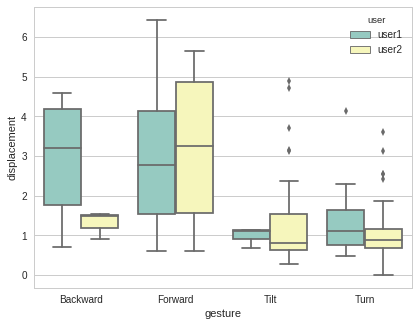

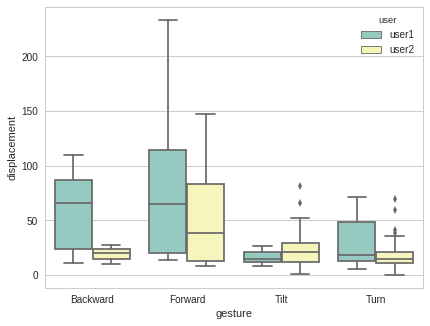

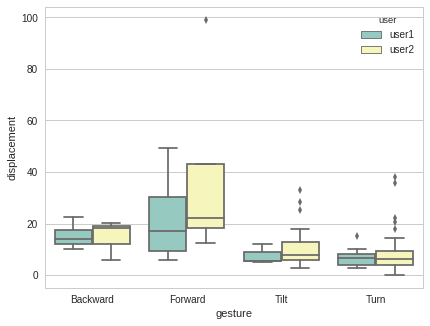

In [13]:
for stat in ['pose_x', 'disp_nosetip_x', 'disp_nosetip_y']:
    df = pd.DataFrame()
    final_stats = {'displacement': [], 'gesture': [], 'user': []}
    # labels, labels_str = [1,2,5,10], ['Nod', 'Jerk', 'Tick', 'Backward']
    labels, labels_str = [6,8,9,10], ['Tilt', 'Turn', 'Forward', 'Backward']
    
    for user_idx, user in enumerate(['043_static.mp4.txt.h5', '040_static.mp4.txt.h5']):
        
        mean_stats, std_stats, value_stats = [], [], []
        gest_type = []
                 
        for k, v in sorted(all_stats_combined.iteritems()):
            if user in k and stat in k and int(k.split('$')[1]) in labels and 'std' not in k:
                mean_stats.append(v['mean'])
                std_stats.append(v['std'])
                value_stats.append(v['values'])
                final_stats['displacement'] += v['values']
                _label_idx = labels.index(int(k.split('$')[1]))
                final_stats['gesture'] += [labels_str[_label_idx]]*len(v['values'])
                u = 'user1' if user_idx == 0 else 'user2'
                final_stats['user'] += [u]*len(v['values'])
                gest_type.append(int(k.split('$')[1]))
        
    data_frame = pd.DataFrame.from_dict(final_stats)
    data_frame['gesture'] = data_frame['gesture'].astype('category')
    data_frame['user'] = data_frame['user'].astype('category')
    
    plot_dataframe_as_boxplot(data_frame, x='gesture', y='displacement', hue='user', gest_labels=labels)